In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.predict import predict
from decode_fish.funcs.evaluation import matching
from decode_fish.funcs.merfish_eval import *
from decode_fish.funcs.exp_specific import *
import kornia

from omegaconf import open_dict
from hydra import compose, initialize

In [12]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '1'

# Training (data taken from starfish MERFISH analysis notebook)
https://spacetx-starfish.readthedocs.io/en/mcai-notebooks-sphinxgallery/gallery/pipelines/merfish_pipeline.html

Load base config. train.yaml contains all hyperparameters, merfish_starfish contains dataset specific information (e.g. number of channels, number of genes, dataset location etc.) that stay fixed across experiments.

In [13]:
initialize(config_path="config")

ValueError: GlobalHydra is already initialized, call GlobalHydra.instance().clear() if you want to re-initialize

In [23]:
cfg = compose(config_name='train.yaml', overrides= ["+exp_type=merfish_starfish"])
cfg = OmegaConf.create(cfg)

[autoreload of decode_fish.engine.place_psfs failed: Traceback (most recent call last):
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 329, in update_class
    if update_generic(old_obj, new_obj):
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 377, in u

Make dataset specific changes

<details><summary>Notes on the MERFISH generative model: **click to expand!** </summary>
    
The basic observation model is given by:
$$Y=DXG+b+\epsilon$$
where Y is the observed multi-channel data, D is the codebook, X is the distribution of transcripts (i.e. the target), G is the PSF and b is additive baseline activity.

Going into more detail these are some additional properties that could be accounted for:
    
1) The data is usually recorded in multiple color channels (here 2, 2 color channels * 8 rounds = 16 bits)
   * This introduces chromatic aberration between the two sets of channels
   * PSFs might be different too
   * We learn separate PSFs (genm.PSF.ncols) as well as chromatic aberration (training.mic.par_grads.color_shifts). 
    
2) There might be small spatial shifts between the color channels (even after alignment during preprocessing)
   * We learn these shifts (training.mic.par_grads.channel_shifts)
    
3) Scaling between channels and colors can vary widely and normalizing it is crucial for performance
   * We can either try to equalize intensities in preprocessing or learn them (training.mic.par_grads.channel_facs)
    
4) As noted in the [supplement](https://www.pnas.org/doi/10.1073/pnas.1612826113) "spot centroids for the same RNA varied in position by ∼100 nm in different imaging rounds, possibly because of the finite cellular volume occupied by each RNA"
   * During simulation we randomly shift the positions across channels for each transcript (genm.microscope.pos_noise_xy / pos_noise_z)
    
5) Just looking at the data we often observe spots that are only visible in single channels and can therefore not be attributed to any code.
   * We simulate such spurious spots with genm.emitter_noise
    
6) At transcription sites we might observe very high local densities of transcripts. (Though these seemed more relevant for smFISH data than for MERFISH?)
   * We simulate such local clusters with the settings in genm.foci. 
    
</details>

In [24]:
# project and run_name set the directories where the trained models are saved, as well as the structure in wandb.ai
cfg.output.project = 'MERFISH_starfish'
cfg.run_name ='MERFISH_sweep_gen_1'

'''Simulation parameters'''
# Average number of foci per simulated volume. If your data does not contain any foci set this to 0.
cfg.genm.foci.n_foci_avg = 1
# Lower and upper limit of emitters simulated per focus
cfg.genm.foci.n_mol_range: [5,40]                       
    
# Sets the emitter density (range of uniform probabilities for a voxel to contain a transcript)
cfg.genm.prob_generator.low = 0.0002
cfg.genm.prob_generator.high = 0.05

# Sets the intensity distribution of the simulation (parametrizes of a gamma distribution)
cfg.genm.intensity_dist.int_conc = 4.
cfg.genm.intensity_dist.int_rate = 1.
cfg.genm.intensity_dist.int_loc = .5

# Multiplicative overall scaling. Should be adjusted to match the oberved intensity values
cfg.genm.microscope.scale = 60

# Background values are sampled by smoothing the real data
cfg.sim.bg_estimation.smoothing.smoothing_filter_size = 9
cfg.sim.roi_mask.percentile = 20

# In addition to real emitters that are sampled from the codebook (and are visible in multiple channels) we sample spurious 'fake' emitters that only show up in a single channel (to make the network more robust)
cfg.genm.emitter_noise.rate_fac = 3.
cfg.genm.emitter_noise.int_fac = 1.

# Noise on the coordinates of individual transcripts across channels
cfg.genm.microscope.pos_noise_z = 0.04
cfg.genm.microscope.pos_noise_xy = 0.5
cfg.training.z_sig_fac = 2.

cfg.genm.noise.theta = [0.287,0.216,0.377,0.321,0.278,0.255,0.483,0.219,0.616,0.374,0.394,0.358,0.44,0.414,0.447,0.244]
    
'''Performance tracking'''
    
# Crop of the training data that is reconstructed for evaluation
cfg.evaluation.reconstruction.crop_sl = 's_[:,:,1500:1650,150:300]'

# Set to 'disabled' if you do not have a wandb account.
cfg.output.wandb_mode = 'online'
cfg.output.log_interval = 500
cfg.evaluation.code_stats.enabled = True

'''Network architecture'''
cfg.network.f_maps = 256
cfg.network.depth = 2
cfg.network.chrom_map = True

'''Training'''
cfg.training.bs = 20
cfg.training.net.opt.lr = 5e-4
cfg.training.mic.norm_reg = 0.

# cfg.training.num_iters = 9995

cfg.training.schedule = [10000, 3000, 5000, 2000, 5000, 2000, 5000, 2000, 5000]
cfg.training.mic.sched.step_size = 2000

cfg.data_path.model_init  = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_1/sl9995//'

# Which parts of the model to train
cfg.training.int.enabled = False
cfg.training.mic.enabled = True
cfg.training.net.enabled = True

cfg.training.mic.par_grads.channel_facs = True
cfg.training.mic.par_grads.channel_shifts = True
cfg.training.mic.par_grads.theta_par = False
cfg.training.mic.par_grads.psf_vol = True
cfg.training.mic.par_grads.color_shifts = True

Save cfg

In [25]:
fname = f'config/experiment/{cfg.run_name}.yaml'
OmegaConf.save(cfg, fname)
prepend_line(fname, '# @package _global_')
cfg.run_name

'MERFISH_sweep_gen_1'

The config file is all you need to train your model. There is a couple of options.  
* You can load the config in the nbs/13_train.ipynb notebook and run all cells. This will continuously produce plots that let you track the training progress.  
* The recommended method is to execute the exeriment in your terminal: "python decode_fish/train.py +experiment=msp300_1"  If you enabled wandb tracking you will get a link for this run.
* You change parameters of your parameters in the command line. For example if you want to run training with a bigger batch size you could execute:  
"python decode_fish/train.py +experiment=MERFISH_sweep_gen_1 training.bs=50 run_name=bs_50"


In [16]:
home_dir = os.getenv("HOME")
print(f'bsub -gpu "num=1" -q gpu_rtx -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode_fish_dev2/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name} run_name=norm:none output.group={cfg.run_name}')

bsub -gpu "num=1" -q gpu_rtx -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=MERFISH_sweep_gen_1 run_name=norm:none output.group=MERFISH_sweep_gen_1


Load data and codebook, show first channel

torch.Size([16, 1, 2048, 2048])


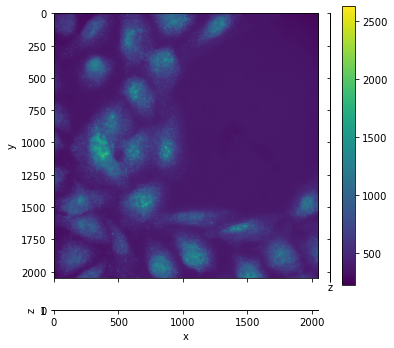

In [17]:
img = load_tiff_image(sorted(glob.glob(cfg.data_path.image_path))[0])
print(img.shape)
_ = plot_3d_projections(img[0][None], size=5, proj_func=np.max)
# sl = eval(cfg.evaluation.reconstruction.crop_sl,{'__builtins__': None},{'s_': np.s_})
# _ = plot_3d_projections(img[0][None][sl[:]], size=5)

Estimate noise scale

In [18]:
thetas = []
for i in range(16):
    bg_est = hydra.utils.instantiate(cfg.sim.bg_estimation.smoothing)(img[i,:,:500,1500:].to('cuda'))
    theta = estimate_noise_scale(img[i,:,:500,1500:], bg_est, percentile=99, plot=False)
#     plt.show()
    thetas.append(theta)

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[0.287 0.216 0.377 0.321 0.278 0.255 0.483 0.219 0.616 0.374 0.394 0.358
 0.44  0.414 0.448 0.244]


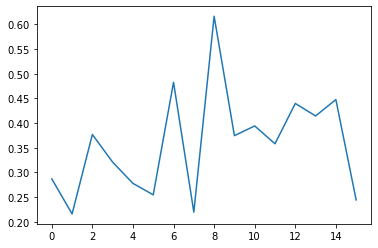

In [19]:
plt.plot(thetas)
print(np.round(thetas,3))

Create the dataloader which samples random subsets from the recorded volumes and generates simulated data that we use for training.  
For visualization purposes it is often better to not sample foci as they distort the colorscale.

In [20]:
n_foci = cfg.genm.foci.n_foci_avg
cfg.genm.foci.n_foci_avg = 0
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)
cfg.genm.foci.n_foci_avg = n_foci

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


This function allows you to visually compare the recorded data and the simulations generated with the given config.  

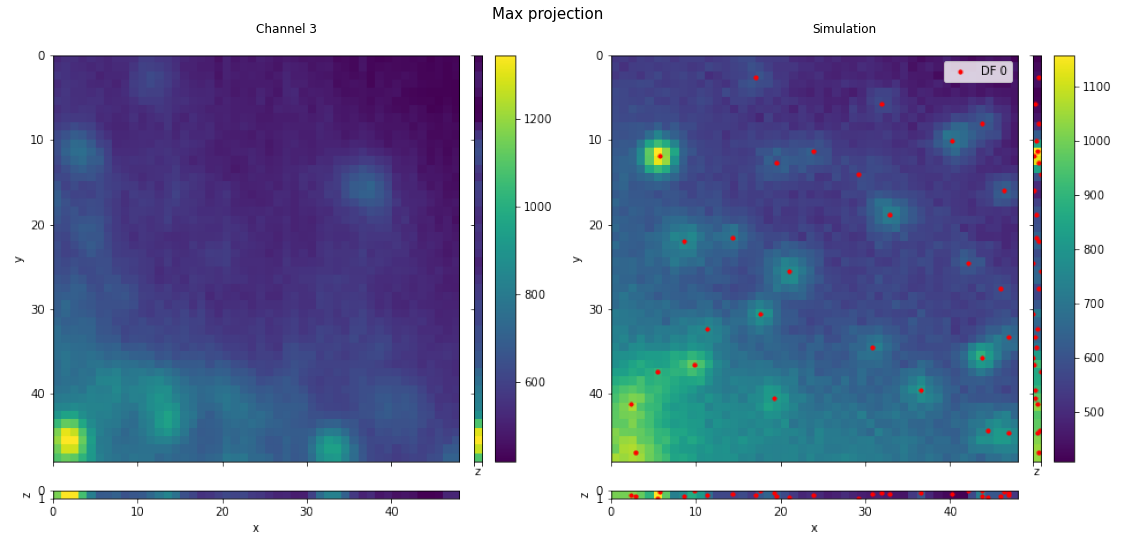

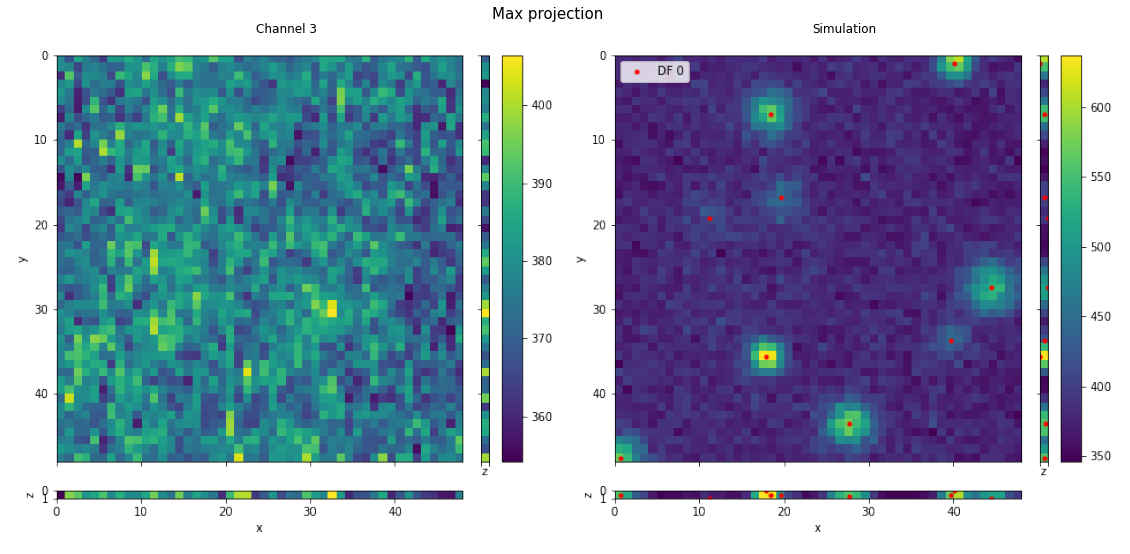

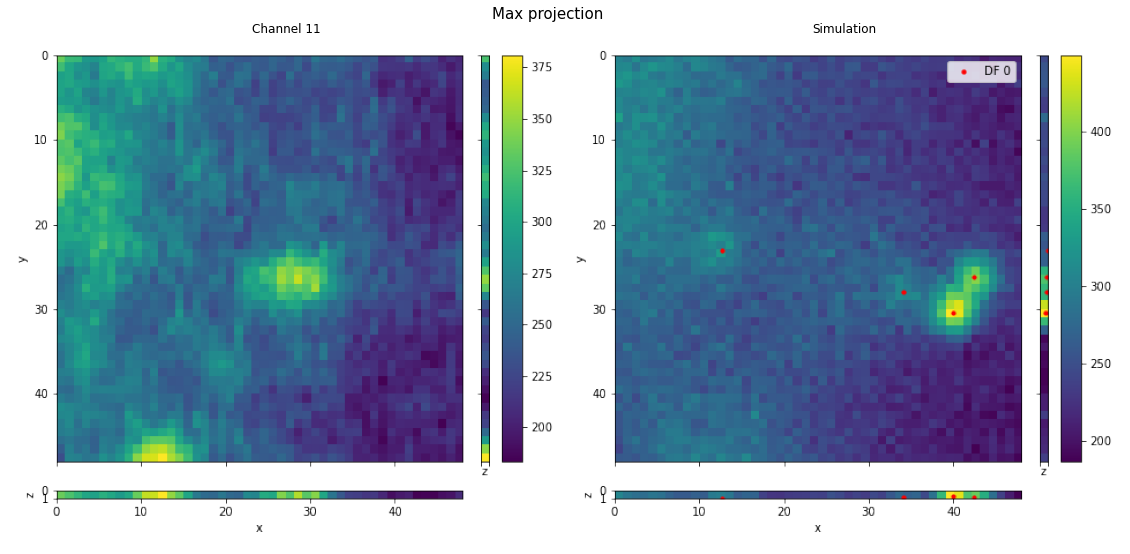

In [22]:
get_simulation_statistics(decode_dl, micro, **cfg.genm.intensity_dist, int_threshold=0.1, samples=3, channels=cfg.genm.exp_type.n_channels, n_bits=cfg.genm.exp_type.n_bits, psf_noise=False)

# Evaluation

In [18]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_1/no_psf/train.yaml')

In [19]:
bench_df, code_ref, targets = get_benchmark()
code_inds = np.stack([np.nonzero(c)[0] for c in code_ref])

13832


In [ ]:
cfg.genm.PSF.fac=1

In [20]:
# Load the model, post processing, imgages, dataloader
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
psf_init = get_vol_psf(cfg.data_path.psf_path, device='cuda', psf_extent_zyx=None)
psf_init = cpu(psf_init.psf_volume)
psf_vol = cpu(micro.psf.psf_volume)
post_proc.codebook = torch.tensor(code_ref)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


Plot mean projections of the PSF before and after optimizing it during training

(tensor(3.7748, device='cuda:0', grad_fn=<DivBackward0>), tensor(10., device='cuda:0', grad_fn=<DivBackward0>), tensor(10., device='cuda:0', grad_fn=<DivBackward0>))


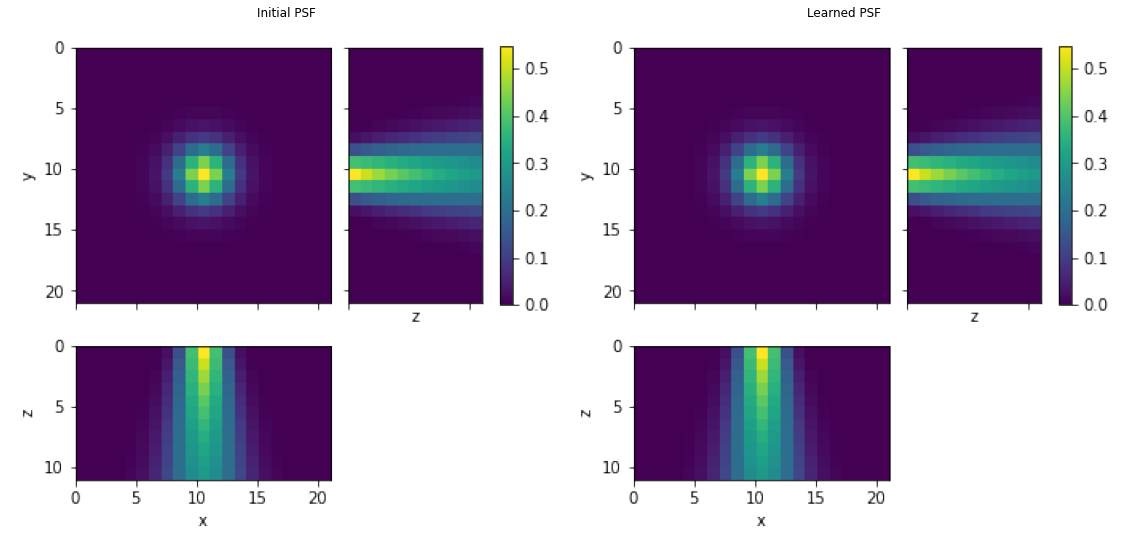

In [21]:
print(micro.psf.get_com())
fig1,_ =plot_3d_projections(psf_init[0], proj_func=np.mean, size=3, display=False)
fig2,_ =plot_3d_projections(psf_vol[0], proj_func=np.mean, size=3, display=False)
_ = combine_figures([fig1,fig2],['Initial PSF','Learned PSF'], nrows=1, ncols=2, figsize=(20,10))

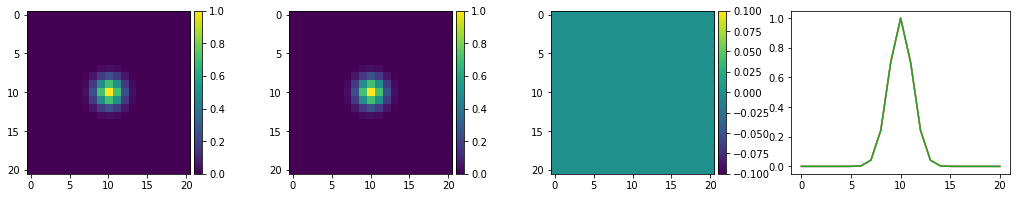

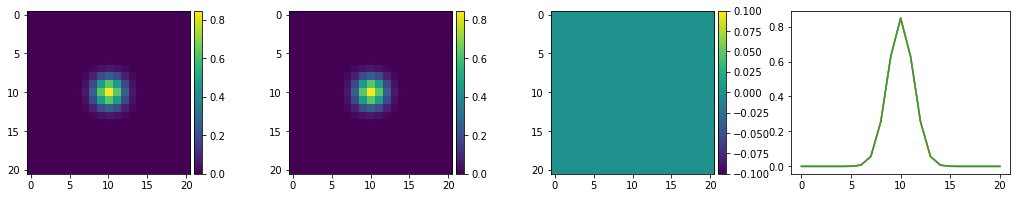

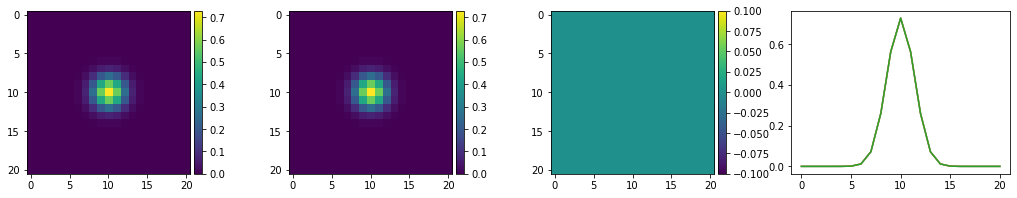

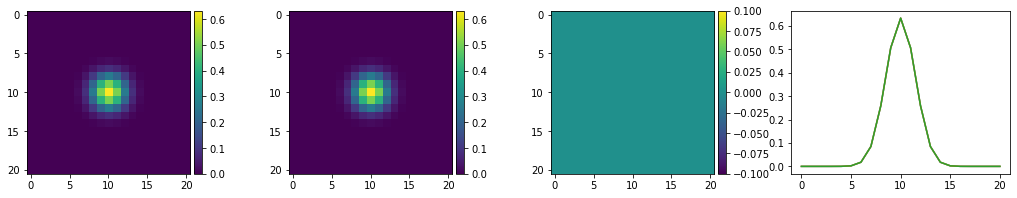

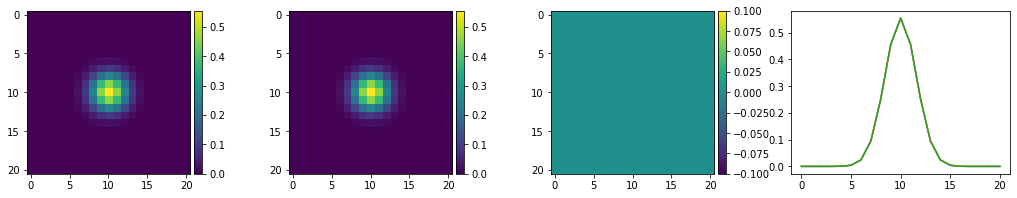

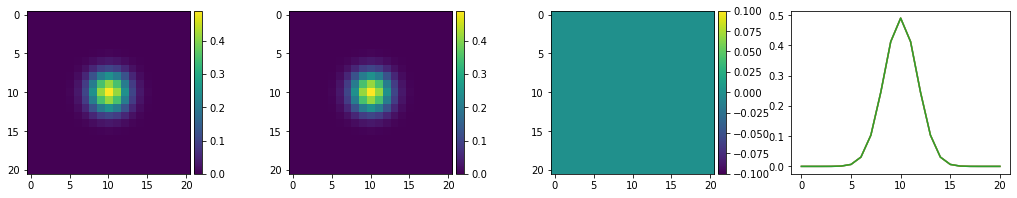

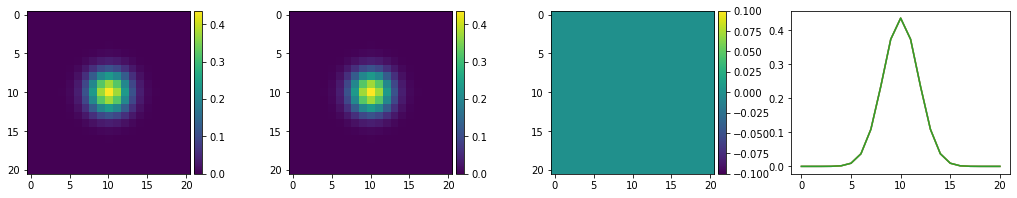

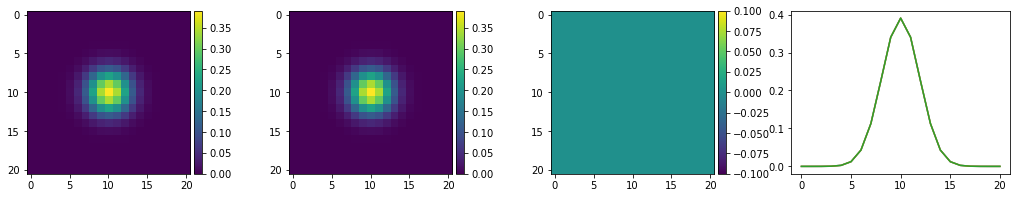

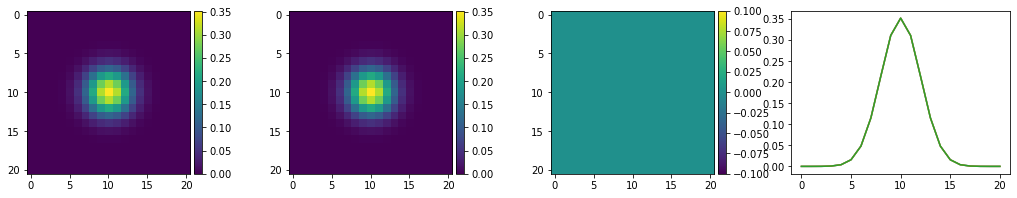

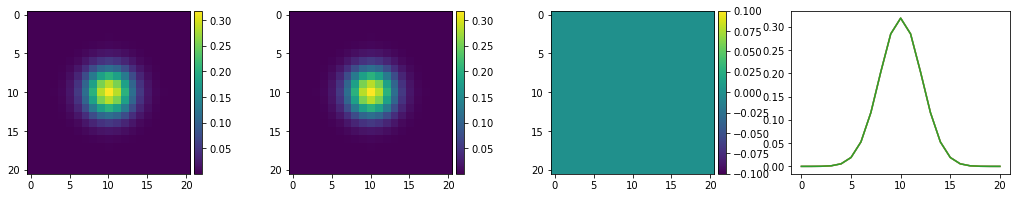

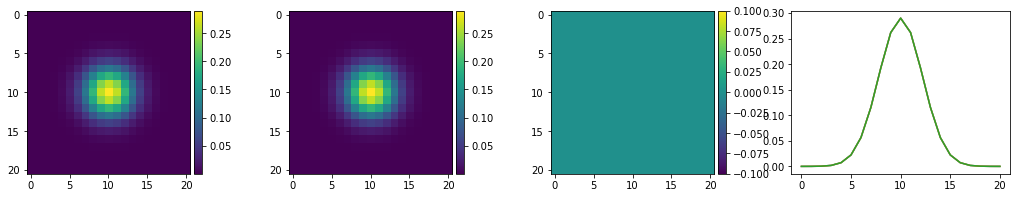

In [26]:
for i in range(len(psf_init[0])):
    plt.figure(figsize=(18,3))
    plt.subplot(141)
    im = plt.imshow(cpu(psf_init)[0,i])
    add_colorbar(im)
    plt.subplot(142)
    im = plt.imshow(cpu(psf_vol)[1,i])
    add_colorbar(im)
    plt.subplot(143)
    im = plt.imshow(cpu(psf_vol-psf_init)[1,i])
    add_colorbar(im)
    plt.subplot(144)
    plt.plot(psf_init[0,i,10])
    plt.plot(psf_vol[0,i,10])
    plt.plot(psf_vol[1,i,10])
    plt.show()

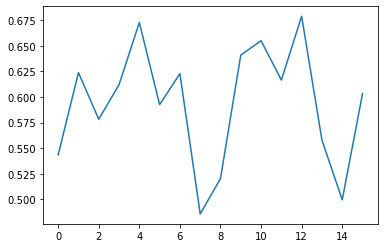

In [27]:
plt.plot(cpu(micro.channel_facs.to('cpu')))

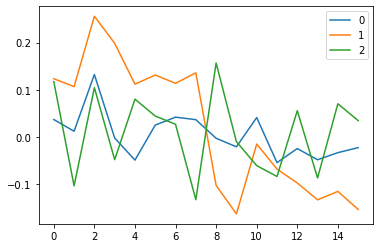

In [28]:
for i in range(3):
    plt.plot(cpu(micro.noise.channel_shifts[:,i]), label=i)
plt.legend()

In [29]:
def plot_aberation_map(img):
    plt.figure(figsize=(10,6))
    for j in range(2):
        plt.subplot(1,2,j+1)
        plt.imshow(img[0,j,:,:])
        plt.colorbar()

In [30]:
upsamp = torch.nn.UpsamplingBilinear2d(size = [2048,2048])
colshift_inp = kornia.filters.gaussian_blur2d(micro.color_shifts[None],  (9,9), (3,3))
colshift_inp = colshift_inp
colshift_inp = cpu(upsamp(colshift_inp))

NameError: name 'kornia' is not defined

In [ ]:
plot_aberation_map(colshift_inp)

Sample random sub volumes and overlay them with predictions,  also shows the residuals between the input volume and the reconstruction from applying the microscope and PSF model to those predictions. Sometimes it looks like the network if missing obvious molecules. Often times this is because they are at the very edge of the volume. In that case they will be localized once you process the whole volume.

In [33]:
from decode_fish.engine.microscope import get_roi_filt_inds, mic_inp_apply_inds, extract_psf_roi
def get_prediction(model, post_proc, img, micro=None, cuda=True, return_rec=False, channel=0):
    
    with torch.no_grad():
        
        img = img[(None,)*(5-img.ndim)]
        model.eval().cuda() if cuda else model.eval().cpu()
        res_dict = model(img.cuda()) if cuda else model(img)
        res_dict = model.tensor_to_dict(res_dict)
        pred_df = post_proc.get_df(res_dict)
        
        if return_rec:
            micro_inp = post_proc.get_micro_inp(res_dict)
            ch_inp = micro.get_single_ch_inputs(*micro_inp)
            ae_img_3d = micro(*ch_inp)   
            
            filt_inds = get_roi_filt_inds(*ch_inp[0], micro.psf.psf_volume.shape, img.shape, slice_rec=micro.slice_rec, min_dist=10)
            ch_inp = mic_inp_apply_inds(*ch_inp, filt_inds)
            if len(ch_inp[1]):
                psf_recs = micro(*ch_inp, ret_psfs=True, add_noise=False)  
#                         print('N rec inds ', len(psf_recs))

                rois = extract_psf_roi(ch_inp[0], img, torch.tensor(psf_recs.shape))
                psf_bgs = extract_psf_roi(ch_inp[0], res_dict['background'], torch.tensor(psf_recs.shape))
            else: 
                psf_recs = rois = psf_bgs = None
            
            return pred_df, ae_img_3d + res_dict['background'], res_dict, psf_recs, psf_bgs, rois, ch_inp
            
        return pred_df

def eval_random_crop(decode_dl, model, post_proc, micro, proj_func=np.max, cuda=False, samples=1, int_threshold=1, plot='rec', crop_sz_xy=40, ret_preds=False):
    
    upsamp = torch.nn.UpsamplingBilinear2d(size = [2048,2048])
    colshift_inp = kornia.filters.gaussian_blur2d(micro.color_shifts[None],  (9,9), (3,3))
    colshift_inp = upsamp(colshift_inp)
    colshift_inp = (colshift_inp * model.inp_scale) + model.inp_offset
    colshift_inp = colshift_inp.detach()
    
    with torch.no_grad():
        
        dl_copy = copy.deepcopy(decode_dl)
        dl_copy.dataset.dataset_tfms[0].crop_sz = (dl_copy.dataset.dataset_tfms[0].crop_sz[0], crop_sz_xy, crop_sz_xy)
        
        if ret_preds: samples = 1
        
        for _ in range(samples):
        
            x = torch.zeros(1)
            while x.max() < int_threshold:
                ret_dict = next(iter(decode_dl))
                x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'] 
                zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
                
                background = background * micro.get_ch_mult().detach()
                x = x * micro.get_ch_mult().detach()
                x = x[:1]
                
                colshift_crop = torch.concat([colshift_inp[:,:,ycrop[i]:ycrop[i]+cfg.sim.random_crop.crop_sz, xcrop[i]:xcrop[i]+cfg.sim.random_crop.crop_sz][:,:,None] for i in range(len(ycrop))], 0)
                colshift_crop = colshift_crop[:1]
                
            rand_ch = np.random.randint(0, x.shape[1])
            print(rand_ch)
            pred_df, rec, res_dict, psf_recs, psf_bgs, rois, ch_inp = get_prediction(model, post_proc, torch.concat([x,colshift_crop], 1), micro=micro, cuda=True, return_rec=True, channel=rand_ch)
            pred_df = nm_to_px(pred_df, post_proc.px_size_zyx)
            
            sub_df = pred_df[code_ref[pred_df['code_inds']][:,rand_ch] > 0]

            x_plot = x[0,rand_ch].cpu().numpy()
            rec = rec[0,rand_ch].cpu().numpy()

            fig1, axes = plot_3d_projections(x_plot, proj_func=proj_func, display=False)
            scat_3d_projections(axes, [sub_df])
            
            if 'res' in plot:

                diff = abs(x_plot-rec)
                fig2, axes = plot_3d_projections(diff, proj_func=proj_func, display=False)
                combine_figures([fig1,fig2], ['Predictions', 'Residual'], figsize=(20,10))
  
            if 'rec' in plot:

                fig2, axes = plot_3d_projections(rec, proj_func=proj_func, display=False)
                combine_figures([fig1,fig2], ['Predictions', 'Reconstruction'], figsize=(20,10))
                
            if 'bg' in plot:

                fig2, axes = plot_3d_projections(res_dict['background'], proj_func=proj_func, display=False)
                combine_figures([fig1,fig2], ['Predictions', 'BG pred.'], figsize=(20,10))
                
            plt.show()
                
        if ret_preds:
            
            return x, local_rate, background, pred_df, rec, res_dict, psf_recs, psf_bgs, rois, ch_inp
                        

8


/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/microscope.py:261: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:607.)
  rois = _extract_psf_roi(x_vol, batch, ch, z, y, x, roi_shape)


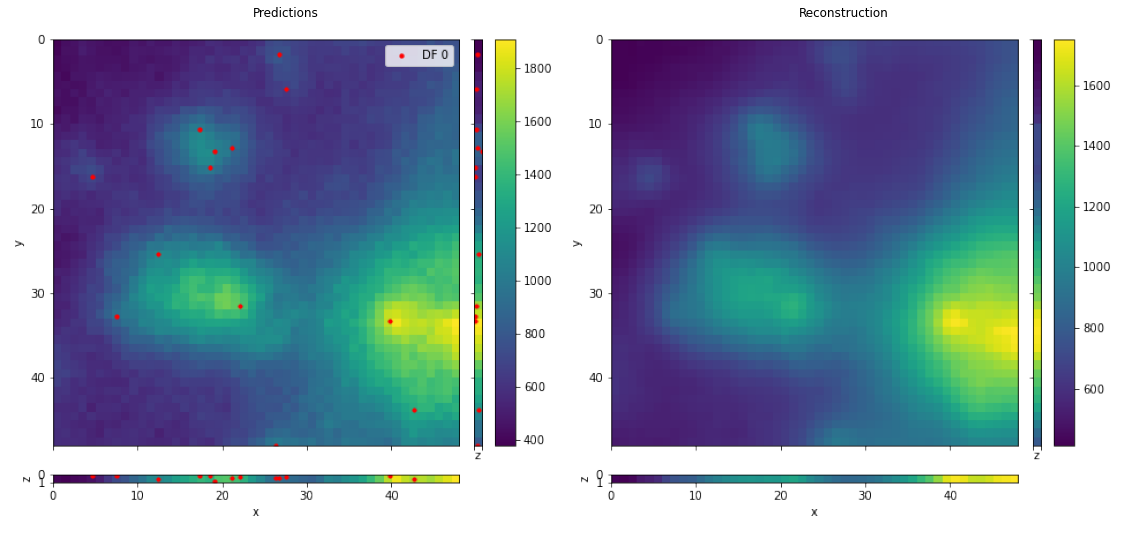

In [34]:
x, local_rate, background, pred_df, rec, res_dict, psf_recs, psf_bgs, rois, ch_inp = eval_random_crop(decode_dl, model, post_proc, micro, plot='rec', crop_sz_xy=100, ret_preds=True)

In [35]:
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *

upsamp = torch.nn.UpsamplingBilinear2d(size = [2048,2048])
colshift_inp = kornia.filters.gaussian_blur2d(micro.color_shifts[None],  (9,9), (3,3))
colshift_inp = upsamp(colshift_inp)
colshift_inp = (colshift_inp * model.inp_scale) + model.inp_offset
colshift_inp = colshift_inp.detach()

def sim_data(decode_dl, batches, micro, model, channels=1, n_bits=1, sim_z=True, codebook=None):
    
    gt_dfs = []
    xsim_col = []
    cols_col = []
    
    for _ in range(batches):
        with torch.no_grad():
            ret_dict = next(iter(decode_dl))
            x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'] 
            zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
            
            background = background * micro.get_ch_mult()
            local_rate *= 2
            
            sim_vars = PointProcessUniform(local_rate[:,0] ,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc, channels=channels, n_bits=n_bits, sim_z=sim_z, codebook=codebook, int_option=cfg.training.int_option).sample(from_code_book=(codebook is not None))
            ch_inp = micro.get_single_ch_inputs(*sim_vars[:-1], ycrop=ycrop.flatten(), xcrop=xcrop.flatten())
            xsim = micro(*ch_inp, add_noise=True, add_pos_noise=True)


            noise_vars = PointProcessUniform(local_rate[:,0] * cfg.genm.emitter_noise.rate_fac, int_conc=model.int_dist.int_conc.detach() * cfg.genm.emitter_noise.int_fac, 
                                           int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(), 
                                           sim_iters=5, channels=cfg.genm.exp_type.n_channels, n_bits=1, 
                                           sim_z=cfg.genm.exp_type.pred_z, codebook=None, int_option=cfg.training.int_option).sample(from_code_book=False)     

            noise_inp = micro.get_single_ch_inputs(*noise_vars[:-1], ycrop=ycrop.flatten(), xcrop=xcrop.flatten())
            xsim += micro(*noise_inp, add_noise=True)
        
            x = micro.noise(xsim, background, const_theta_sim=cfg.genm.exp_type.const_theta_sim).sample()

            xsim_col.append(x)
            colshift_crop = torch.concat([colshift_inp[:,:,ycrop[i]:ycrop[i]+cfg.sim.random_crop.crop_sz, xcrop[i]:xcrop[i]+cfg.sim.random_crop.crop_sz] for i in range(len(ycrop))], 0)
            cols_col.append(colshift_crop[:,:,None])
#             xsim_col.append(torch.concat([x,colshift_crop[:,:,None]], 1))

            gt_vars = sim_vars[:-2] 
            gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])
            gt_dfs.append(gt_df)
        
    return torch.cat(xsim_col), torch.cat(cols_col), cat_emitter_dfs(gt_dfs, decode_dl.batch_size)

def get_sim_perf(x, gt_df, model, post_proc, micro, cuda=True, print_res=True):

    pred_dfs = []
    x_recs = []
    
    for i in range(len(x)):
        with torch.no_grad():
#             pred_df, rec, res_dict, _, _, _, _ = get_prediction(model, post_proc, x[i:i+1], micro=micro, cuda=True, return_rec=True)
            pred_df = get_prediction(model, post_proc, x[i:i+1], micro=micro, cuda=True, return_rec=False)
            pred_dfs.append(pred_df)
#             x_recs.append(rec)
        
    pred_df = cat_emitter_dfs(pred_dfs)
#     xrec = torch.cat(x_recs)
    perf, matches, _ = matching(gt_df, pred_df, tolerance=1000, print_res=print_res, match_genes=True, allow_multiple_matches=True)
#     perf['mae'] = abs(xrec-rec).mean().item()
#     perf['rmse'] = torch.sqrt(((xrec-rec)**2).mean()).item()
    res_dict = None
    return perf, pred_df, matches, res_dict

In [38]:
# from decode_fish.funcs.routines import *
xsim, cols, gt = sim_data(decode_dl, 50, micro, model, channels=16, n_bits=4, sim_z=cfg.genm.exp_type.pred_z, codebook=torch.tensor(code_ref))
# perf, pred_df, matches, res_dict = get_sim_perf(xsim, px_to_nm(gt, cfg.evaluation.px_size_zyx), model, post_proc, micro, print_res=True)pred_df

[autoreload of decode_fish.engine.place_psfs failed: Traceback (most recent call last):
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 329, in update_class
    if update_generic(old_obj, new_obj):
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 377, in u

In [39]:
perf, pred_df, matches, res_dict = get_sim_perf(torch.concat([xsim,cols], 1), px_to_nm(gt, cfg.evaluation.px_size_zyx), model, post_proc, micro, print_res=True)

Recall: 0.278
Precision: 0.872
Jaccard: 26.750
RMSE_vol: 120.172
Eff_3d: 5.259
FN: 113319.0 FP: 6414.0
Num. matches: 43725.000
Shift: 1.19,-0.24,1.92


In [40]:
pred_df.loc[:, 'class'] = 1
pred_df.loc[pred_df['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0

In [41]:
pred_df['tot_int'] = pred_df['int_0']+pred_df['int_1']+pred_df['int_2']+pred_df['int_3']
pred_df['tot_int_sig'] = pred_df['int_sig_0']+pred_df['int_sig_1']+pred_df['int_sig_2']+pred_df['int_sig_3']

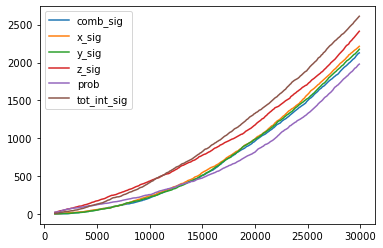

In [42]:
def make_roc(df, var='code_err', ascending=True, n_max=30000):
    
    if n_max is None:
        n_max = len(df)
    x = np.arange(1000,n_max,100)
    df = df.sort_values(var, ascending=ascending)
    n_blanks = []
    for i in x:
        n_blanks.append((df[:int(i)]['class']==1).sum())
        
    return x, n_blanks

for k in ['comb_sig','x_sig','y_sig','z_sig','prob','tot_int_sig']:
    b = False if k in ['tot_int','prob'] else True
    r  = make_roc(pred_df, k, n_max=30000, ascending=b)
    plt.plot(r[0],r[1], label=k)
plt.legend()

If you are happy with the results you can run the network on whole volumes to get predictions. Be aware that a model will only produce good results on different recordings if the conditions with regards to PSF and intensity are similar as those used during training.

In [43]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

keys = ['x_sig','y_sig','z_sig','prob']

X = np.concatenate([pred_df[keys].values])
y = np.concatenate([pred_df['class'].values])
 
clf = LogisticRegressionCV(random_state=1,max_iter=10000, class_weight='balanced').fit(X, y)

In [44]:
X = np.concatenate([pred_df[keys].values])
pred_df['score'] = clf.predict_proba(X)[:,1]

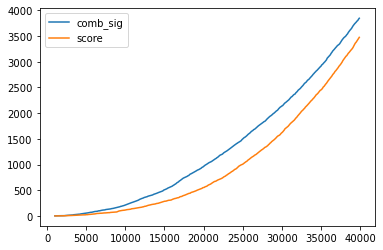

In [46]:
for k in ['comb_sig','score']:
    r  = make_roc(pred_df, k, n_max=40000, ascending=True)
    plt.plot(r[0],r[1], label=k)
plt.legend()

In [47]:
clf.coef_[0]

array([ 0.03013845,  0.03222997,  0.02287307, -2.58878775])

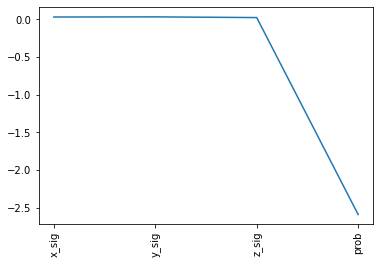

In [48]:
plt.plot(clf.coef_[0])
_ = plt.xticks(ticks=np.arange(len(keys)),labels=keys, rotation=90)

In [233]:
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sl_14/int_option:1//train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sl_14c/loss_option:1xcount_mult:0xcat_logits:0/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sl_19b/start_mic:200000xstart_int:200000xrate_fac:0xn_dump_codes:0xbs:3/train.yaml')

In [234]:
# cfg.output.save_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/nb_run/test/'

In [182]:
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


In [183]:
# for p in micro.parameters():
# #     p.requires_grad = False
#     print(p, p.requires_grad)

In [52]:
import kornia
from monai.inferers import sliding_window_inference
from decode_fish.funcs.exp_specific import *
from decode_fish.funcs.predict import merfish_predict

upsamp = torch.nn.UpsamplingBilinear2d(size = [2048,2048])
colshift_inp = kornia.filters.gaussian_blur2d(micro.color_shifts[None],  (9,9), (3,3))
colshift_inp = upsamp(colshift_inp)
colshift_inp = (colshift_inp * model.inp_scale) + model.inp_offset
colshift_inp = colshift_inp.detach()

def merfish_predict(model, post_proc, image_paths, window_size=[None,256,256], crop=np.s_[:,:,:,:,:], bs=1, device='cuda', chrom_map=None, scale=None):
    pred_df = DF()
    with torch.no_grad():
        for p in image_paths:
#             print(p.split('/')[-1])
            if 'aligned' in p:
                from decode_fish.funcs.exp_specific import read_MOp_tiff
                img = read_MOp_tiff(p, scaled=False, z_to_batch=True)
            else:
                img = load_tiff_image(p)
                
            print(img.shape)
            if img.ndim == 4:
                img = img[None]
            
            n_batches = int(np.ceil(len(img)/bs))
            
            if scale is not None:
                img = img * scale.to(img.device)
            
            if chrom_map is not None:
                img = torch.concat([img,chrom_map.to(img.device).repeat_interleave(len(img),0)], 1)
                
            for i in tqdm(range(n_batches)):
                
                inp = img[i*bs:(i+1)*bs][crop]
                output = sliding_window_inference(inp, window_size, 1, model.to(device), overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
                output = model.tensor_to_dict(output)
                p_si = sliding_window_inference(output['logits'], window_size, 1, post_proc, overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
                i_df = post_proc.get_df(output, p_si)
#                 i_df.loc[:,'frame_idx'] += i*bs
                pred_df = append_emitter_df(pred_df, i_df)
                free_mem()
        return pred_df

In [53]:
from decode_fish.funcs.predict import *

res_df = merfish_predict(model, post_proc, [cfg.data_path.image_path], window_size=[None, 256, 256], device='cuda', chrom_map=torch.tensor(colshift_inp)[:,:,None], scale=micro.get_ch_mult())
res_df = exclude_borders(res_df, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100])

/tmp/ipykernel_11421/2521697514.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  res_df = merfish_predict(model, post_proc, [cfg.data_path.image_path], window_size=[None, 256, 256], device='cuda', chrom_map=torch.tensor(colshift_inp)[:,:,None], scale=micro.get_ch_mult())


torch.Size([16, 1, 2048, 2048])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.70s/it]


In [54]:
from decode_fish.funcs.merfish_eval import *
bench_df, code_ref, targets = get_benchmark()
bench_df = bench_df[bench_df['gene'] != 'MALAT1']

13832


In [55]:
# from decode_fish.funcs.predict import *
# image_paths = sorted(glob.glob(cfg.data_path.image_path))
# image_paths = ['/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish_scaled//img_stack.tiff']
# inf_dfs = merfish_predict(model, post_proc, image_paths=image_paths, window_size=[None, 256, 256], device='cuda')
# # inf_df.to_csv(f'../data/results/MERFISH/test.csv', index=False)

In [56]:
# res_df = exclude_borders(inf_dfs, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100])
res_df['gene'] = targets[res_df['code_inds']]
res_df = res_df[res_df['gene'] != 'MALAT1'] 
res_df['x'] += 100
res_df['y'] += 100

In [57]:
res_single = remove_doublets(res_df, tolerance=200)
print(len(res_single)/len(res_df))

0.957280385078219


In [58]:
# res_df1.to_csv(f'../data/results/MERFISH/test.csv', index=False)

In [59]:
matches2, bench_match = match_bench(res_df, bench_df)

[4.877669859590671, 2.497407205646121, -6.683289304828144]
Recall: 0.837
Precision: 0.527
Jaccard: 47.763
RMSE_vol: 87.889
Eff_3d: 31.737
FN: 2050.0 FP: 9439.0
Num. matches: 10505.000
Shift: -0.00,-0.00,0.00


In [40]:
matches2, bench_match, shifts = matching(res_df, bench_df)

Recall: 0.530
Precision: 0.764
Jaccard: 45.517
RMSE_vol: 100.935
Eff_3d: 25.735
FN: 9379.0 FP: 3267.0
Num. matches: 10565.000
Shift: -4.52,-1.95,6.69


In [60]:
bench_counts = DF(data=None, index=targets)
bench_counts['Res_all'] = res_df.groupby('gene')['gene'].count()
bench_counts['Bench_all'] = bench_df.groupby('gene')['gene'].count()
bench_counts = bench_counts.fillna(0)
r = np.corrcoef(bench_counts['Bench_all'].values, bench_counts['Res_all'].values)[0, 1]   

12555 19944


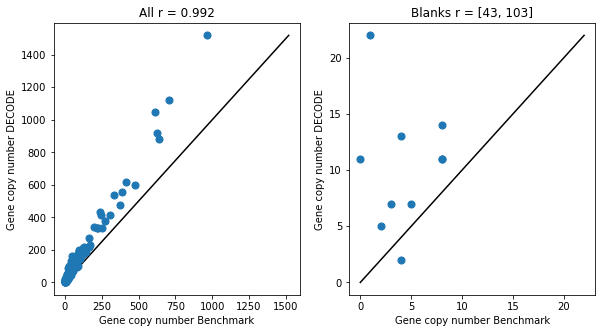

In [61]:
plot_gene_panels(res_df, bench_match, targets)

12555 12500


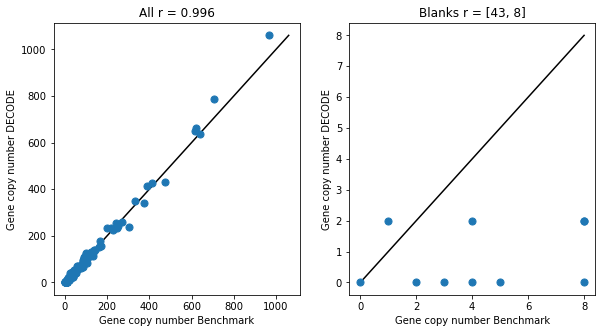

In [66]:
plot_gene_panels(res_single.nsmallest(12500, 'score'), bench_match, targets)

In [64]:
X = np.concatenate([res_single[keys].values])
res_single['score'] = clf.predict_proba(X)[:,1]

/tmp/ipykernel_11421/4042383351.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_single['score'] = clf.predict_proba(X)[:,1]


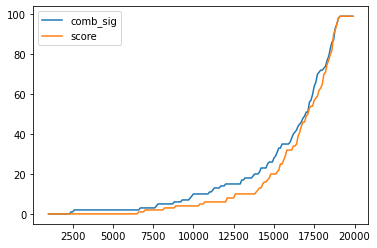

In [67]:
def make_roc(df, var='code_err', ascending=True, n_max=50000):
    
    if n_max is None:
        n_max = len(df)
    x = np.arange(1000,n_max,100)
    df = df.sort_values(var, ascending=ascending)
    n_blanks = []
    for i in x:
        n_blanks.append((df[:int(i)]['gene'].str.contains('Blank')).sum())
        
    return x, n_blanks

for k in ['comb_sig','score']:
    r  = make_roc(res_single, k, n_max=20000, ascending=True)
    plt.plot(r[0],r[1], label=k)
plt.legend()

In [99]:
res_df1.to_csv(f'../data/results/MERFISH/test.csv', index=False)

In [599]:
img_stack_o = load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish/img_stack.tiff')
img_stack_s = load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish_scaled//img_stack.tiff')

In [227]:
# sl = np.s_[0,700:1200,300:800]
# # malat = 7,  8, 13, 14
# for i in range(16):

#     plt.figure(figsize=(20,8))
#     im = plt.imshow(img_stack[i][sl])
#     add_colorbar(im)

In [604]:
sl = np.s_[:,:,500:1250,1100:1700]
sl = np.s_[:,:,:,:]
img = load_tiff_image(image_paths[0])
for i in range(16):

    preds_px = nm_to_px(inf_df[inf_df['frame_idx']==(i)])
    plt.figure(figsize=(25,25))
    im = plt.imshow(img[i,0][sl[2:]])
    add_colorbar(im)
    sub_preds = crop_df(preds_px, sl)
    plt.scatter(sub_preds['x'],sub_preds['y'], color='red', s=3.5)
    plt.show()

TypeError: 'NoneType' object is not subscriptable

In [255]:
import mpld3
from mpld3 import plugins
code_cols = [plt.get_cmap('gist_ncar')(x) for x in np.linspace(0.,1.,140)]

29555


(600.0, 750.0)

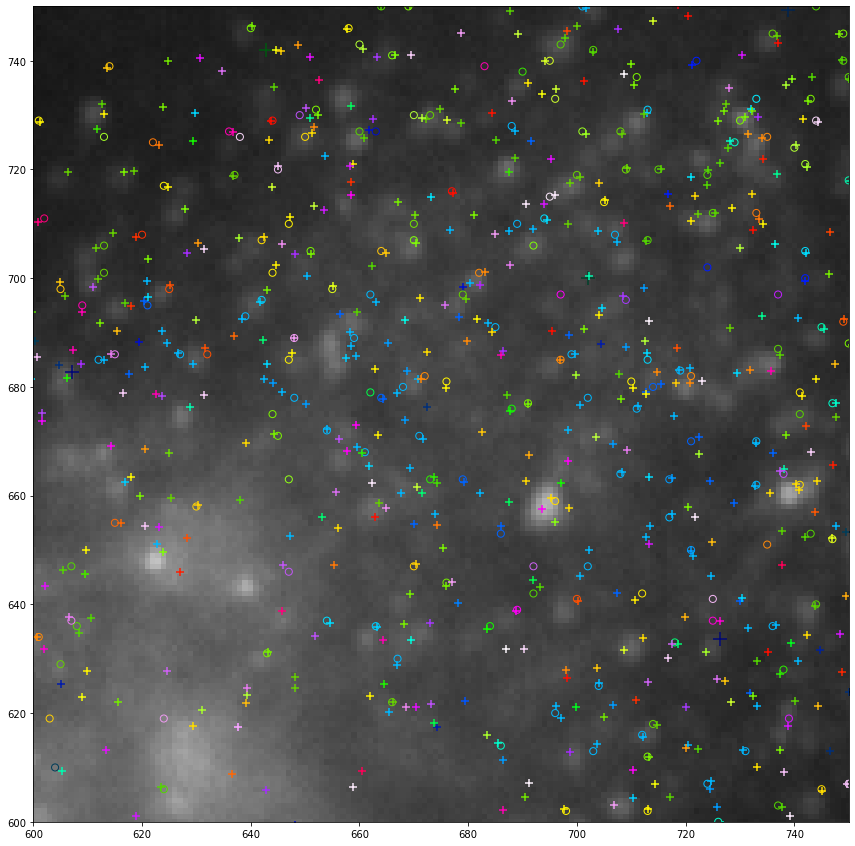

In [256]:
ind = 0
img = load_tiff_image(cfg.data_path.image_path)
preds_px = nm_to_px(res_single)#[res_df['gene']!='MALAT1']
bench_px = nm_to_px(bench_df)#[bench_df['gene']!='MALAT1']
print(len(preds_px))
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img[0,0], cmap='gray')

for i in range(len(targets)):
    
    preds_sub = preds_px[preds_px['code_inds'] == i]
    bench_sub = bench_px[bench_px['code_inds'] == i]
    
    size = 200. if 'Blank' in targets[i] else 50.

    ax.scatter(bench_sub['x'],bench_sub['y'], color=code_cols[i], s=size, marker='o', facecolor='none')
    ax.scatter(preds_sub['x'],preds_sub['y'], color=code_cols[i], s=size, marker='+')

ax.set_xlim(600,750)
ax.set_ylim(600,750)

# plugins.connect(fig, plugins.MousePosition(fontsize=14))
# mpld3.display()

In [254]:
for i in range(4):
    for j in range(i+1,4):
        print(i,j,np.corrcoef(res_single[f'int_{i}'], res_single[f'int_{j}'])[0,1])

0 1 0.07120999857339837
0 2 0.1351865230633996
0 3 -0.09645277830978242
1 2 -0.07322307972781757
1 3 -0.0242176467533459
2 3 0.0977937502311161


In [262]:
int_keys = [f'int_{i}' for i in range(4)]
ints = res_single.loc[:,int_keys].values

Text(0.5, 0, 'four highest probablities')

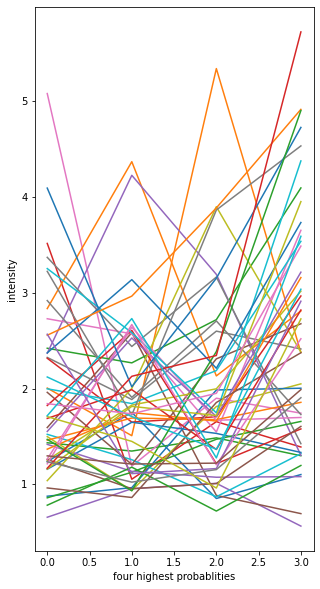

In [264]:
plt.figure(figsize=(5,10))
for i in range(100,150):
    plt.plot(ints[i])
plt.ylabel('intensity')
plt.xlabel('four highest probablities')